In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import talib
import sys
import os
sys.path.append(os.path.abspath(".."))  # if you're inside notebooks/

from scripts.news_utils import (
    load_news_data,
    parse_dates,
    filter_by_ticker,
    daily_article_counts,
    plot_daily_article_frequency
)

In [2]:
ticker = 'TSLA'
news_path = '../data/raw_analyst_ratings.csv'
stock_path = f'../data/yfinance_data/{ticker}_historical_data.csv'

# ------------------ Load & Preprocess News Data ------------------
df_news = load_news_data(news_path)
df_news = parse_dates(df_news)
df_news_tsla = filter_by_ticker(df_news, ticker)

print("\nTSLA News Data Info:")
print(df_news_tsla.info())


TSLA News Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1875 entries, 1255221 to 1257095
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   headline   1875 non-null   object             
 1   url        1875 non-null   object             
 2   publisher  1875 non-null   object             
 3   date       1875 non-null   datetime64[ns, UTC]
 4   stock      1875 non-null   object             
 5   date_only  1875 non-null   object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 102.5+ KB
None


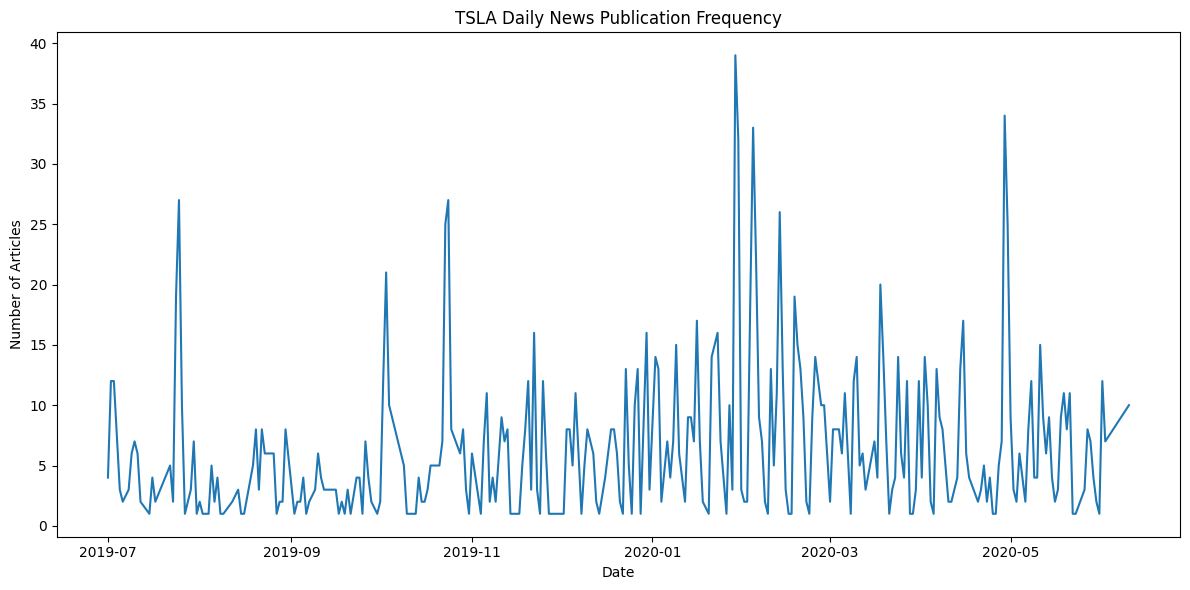


TSLA Stock Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1279 entries, 2019-07-01 to 2024-07-30
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1279 non-null   float64
 1   High          1279 non-null   float64
 2   Low           1279 non-null   float64
 3   Close         1279 non-null   float64
 4   Adj Close     1279 non-null   float64
 5   Volume        1279 non-null   int64  
 6   Dividends     1279 non-null   float64
 7   Stock Splits  1279 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 89.9 KB
None


/tmp/ipykernel_5554/2864839960.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2020-06-10 21:02:47', '2020-06-10 19:08:09', '2020-06-10 16:41:58',
 '2020-06-10 15:33:18', '2020-06-10 14:15:07', '2020-06-10 13:58:54',
 '2020-06-10 13:00:24', '2020-06-10 12:43:13', '2020-06-10 12:14:33',
 '2020-06-10 11:55:49',
 ...
 '2019-07-02 00:00:00', '2019-07-02 00:00:00', '2019-07-02 00:00:00',
 '2019-07-02 00:00:00', '2019-07-02 00:00:00', '2019-07-02 00:00:00',
 '2019-07-01 00:00:00', '2019-07-01 00:00:00', '2019-07-01 00:00:00',
 '2019-07-01 00:00:00']
Length: 1875, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  df_news_tsla.loc[:, 'date'] = pd.to_datetime(df_news_tsla['date'], utc=True).dt.tz_localize(None)


In [3]:
# ------------------ Visualize News Frequency ------------------
daily_counts = daily_article_counts(df_news_tsla)
plot_daily_article_frequency(daily_counts, title=f'{ticker} Daily News Publication Frequency')

# ------------------ Load Stock Price Data ------------------
df_stock = pd.read_csv(stock_path)
df_news_tsla.loc[:, 'date'] = pd.to_datetime(df_news_tsla['date'], utc=True).dt.tz_localize(None)


df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.set_index('Date', inplace=True)
df_stock = df_stock[df_stock.index >= df_news_tsla['date'].min()]  # Align with news

print("\nTSLA Stock Data Info:")
print(df_stock.info())

In [4]:
# ------------------ Technical Indicators ------------------
df_stock['SMA_20'] = talib.SMA(df_stock['Close'], timeperiod=20)
df_stock['EMA_20'] = talib.EMA(df_stock['Close'], timeperiod=20)
df_stock['RSI'] = talib.RSI(df_stock['Close'], timeperiod=14)
df_stock['MACD'], df_stock['MACD_Signal'], df_stock['MACD_Hist'] = talib.MACD(
    df_stock['Close'], fastperiod=12, slowperiod=26, signalperiod=9
)

In [5]:
# ------------------ Financial Metrics ------------------
df_stock['Daily_Return'] = df_stock['Close'].pct_change() * 100
df_stock['Volatility'] = df_stock['Daily_Return'].rolling(window=20).std()


TSLA with Indicators and Metrics:
                 Close      SMA_20        RSI  Daily_Return       MACD  \
Date                                                                     
2024-07-24  215.990005  237.924999  44.886918    -12.334605  11.789291   
2024-07-25  220.250000  239.118999  46.951389      1.972311   9.353206   
2024-07-26  219.800003  240.238000  46.752165     -0.204312   7.302106   
2024-07-29  232.100006  241.949000  52.664511      5.595998   6.593101   
2024-07-30  222.619995  242.587000  48.220474     -4.084451   5.206237   

            MACD_Signal  MACD_Hist  
Date                                
2024-07-24    15.873789  -4.084498  
2024-07-25    14.569672  -5.216466  
2024-07-26    13.116159  -5.814053  
2024-07-29    11.811547  -5.218447  
2024-07-30    10.490485  -5.284248  


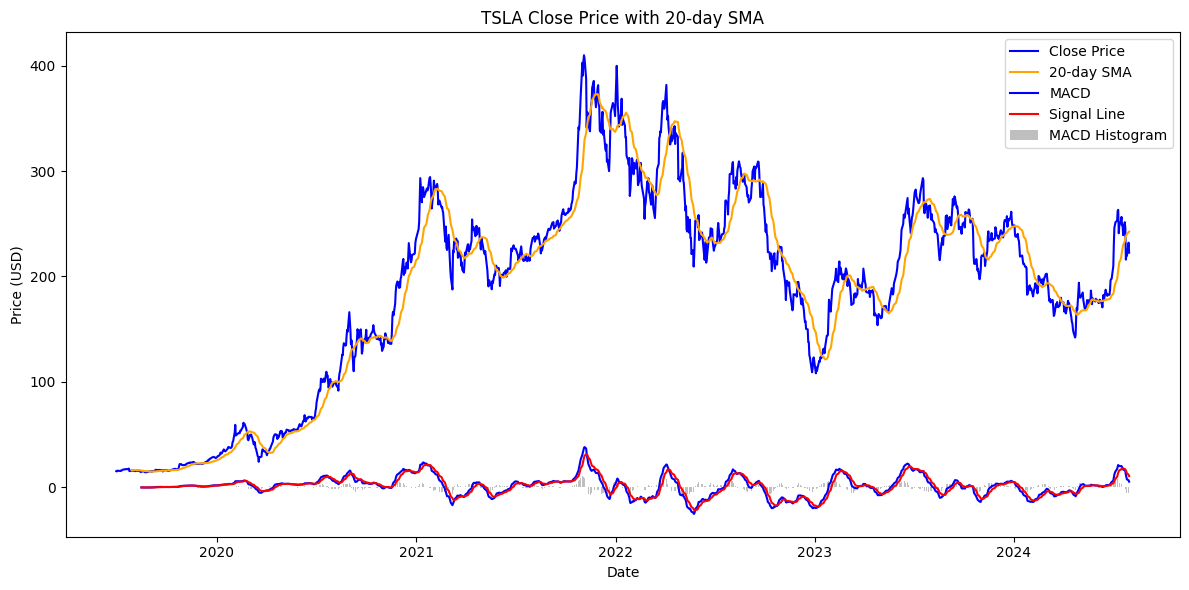

In [6]:
# ------------------ Inspect & Visualize ------------------
print("\nTSLA with Indicators and Metrics:")
print(df_stock[['Close', 'SMA_20', 'RSI', 'Daily_Return', 'MACD', 'MACD_Signal', 'MACD_Hist']].tail())


# Plot Close Price with SMA
plt.figure(figsize=(12, 6))
plt.plot(df_stock['Close'], label='Close Price', color='blue')
plt.plot(df_stock['SMA_20'], label='20-day SMA', color='orange')
plt.plot(df_stock.index, df_stock['MACD'], label='MACD', color='blue')
plt.plot(df_stock.index, df_stock['MACD_Signal'], label='Signal Line', color='red')
plt.bar(df_stock.index, df_stock['MACD_Hist'], label='MACD Histogram', color='gray', alpha=0.5)


plt.title(f'{ticker} Close Price with 20-day SMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()